pip install pandas numpy nltk spacy sentence-transformers scikit-learn
python -m spacy download en_core_web_sm


## Step 1: Organizing Transcriptions

In [ ]:
import os
import glob
import pandas as pd

def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = file  # Keep track of the source file
        data_frames.append(df)
    return data_frames

# Example usage:
directory = 'data/rawTranscriptFiles'
transcript_dfs = read_csv_files(directory)


Processing Each Transcription Separately
We'll iterate over each DataFrame in transcript_dfs and process them individually.

In [ ]:
import re
import nltk
import spacy

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities


Now, process each transcription:

In [ ]:
for df in transcript_dfs:
    df['cleaned_transcript'] = df['transcript'].apply(preprocess_text)
    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )


Comparing Transcriptions
Since each transcription is processed separately, you can now compare them in various ways.



## Step 3: Topic Modeling and Semantic Similarities Across Transcriptions
Generating Sentence Embeddings for Each Transcription
We'll generate embeddings for each transcription and store them.



In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

# Store embeddings and related info
embeddings_list = []
file_names = []

for df in transcript_dfs:
    text = ' '.join(df['cleaned_transcript'])
    embedding = model.encode(text)
    embeddings_list.append(embedding)
    file_names.append(df['source_file'])


Comparing Transcriptions Using Semantic Similarity
We'll compute the cosine similarity between each pair of transcriptions.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert list of embeddings to a numpy array
embeddings_array = np.vstack(embeddings_list)

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_array)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)

print(similarity_df)


# Visualizing the Similarity Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Semantic Similarity Between Transcriptions')
plt.show()


# Topic Modeling on Individual Transcriptions
Since you want to compare topics between transcriptions, you can perform topic modeling on each transcription separately.

Using Latent Dirichlet Allocation (LDA)
First, you need to prepare the data for LDA:

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

def perform_lda(tokens_list, num_topics=5):
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(tokens_list)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=1, no_above=0.5)

    # Create a bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]

    # Train the LDA model
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary


Now, apply LDA to each transcription:

In [ ]:
lda_models = []

for df in transcript_dfs:
    tokens_list = df['tokens'].tolist()
    lda_model, corpus, dictionary = perform_lda(tokens_list)
    lda_models.append({
        'model': lda_model,
        'corpus': corpus,
        'dictionary': dictionary,
        'source_file': df['source_file'].iloc[0]
    })


# Comparing Topics Between Transcriptions
You can now inspect the topics from each transcription and compare them.

In [ ]:
for lda_info in lda_models:
    print(f"Topics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')


# Combined

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                                    data/rawTranscriptFiles\Monologue1_transcription.csv  \
data/rawTranscriptFiles\Monologue1_transcriptio...                                                1.0      
data/rawTranscriptFiles\Monologue2_transcriptio...                                                1.0      
data/rawTranscriptFiles\Monologue_transcription...                                                1.0      

                                                    data/rawTranscriptFiles\Monologue2_transcription.csv  \
data/rawTranscriptFiles\Monologue1_transcriptio...                                                1.0      
data/rawTranscriptFiles\Monologue2_transcriptio...                                                1.0      
data/rawTranscriptFiles\Monologue_transcription...                                                1.0      

                                                    data/rawTranscriptFiles\Monologue_transcription.csv  
data/rawTranscriptFiles\Mono

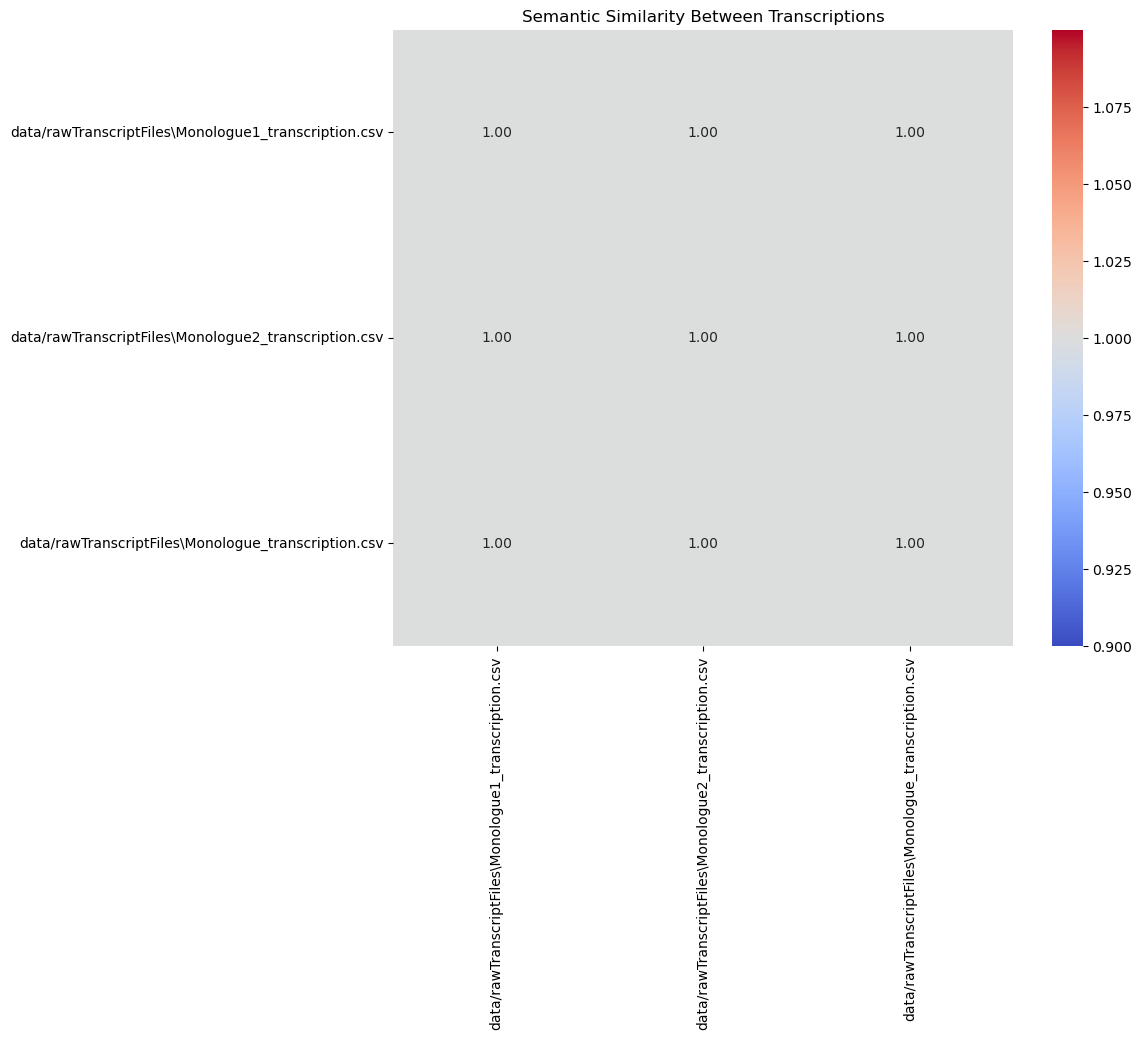

Topics for data/rawTranscriptFiles\Monologue1_transcription.csv:
(0, '0.063*"business" + 0.063*"things" + 0.063*"well" + 0.063*"pick" + 0.063*"see"')
(1, '0.074*"every" + 0.074*"would" + 0.074*"like" + 0.074*"keep" + 0.040*"two"')
(2, '0.061*"royalties" + 0.061*"maintain" + 0.061*"current" + 0.034*"suggest" + 0.034*"gon"')
(3, '0.064*"pay" + 0.064*"agreement" + 0.064*"possible" + 0.064*"soon" + 0.064*"license"')
(4, '0.096*"suggest" + 0.053*"outstanding" + 0.053*"royalties" + 0.052*"two" + 0.052*"set"')


Topics for data/rawTranscriptFiles\Monologue2_transcription.csv:
(0, '0.063*"business" + 0.063*"things" + 0.063*"well" + 0.063*"pick" + 0.063*"see"')
(1, '0.074*"every" + 0.074*"would" + 0.074*"like" + 0.074*"keep" + 0.040*"two"')
(2, '0.061*"royalties" + 0.061*"maintain" + 0.061*"current" + 0.034*"suggest" + 0.034*"gon"')
(3, '0.064*"pay" + 0.064*"agreement" + 0.064*"possible" + 0.064*"soon" + 0.064*"license"')
(4, '0.096*"suggest" + 0.053*"outstanding" + 0.053*"royalties" + 0.052*"t

In [3]:
import os
import glob
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Setup
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stop_words = set(nltk.corpus.stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Functions
def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = file  # Keep track of the source file
        data_frames.append(df)
    return data_frames

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

def perform_lda(tokens_list, num_topics=5):
    dictionary = Dictionary(tokens_list)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary

# Execution
directory = 'data/rawTranscriptFiles'
transcript_dfs = read_csv_files(directory)

embeddings_list = []
file_names = []
lda_models = []

for df in transcript_dfs:
    df['cleaned_transcript'] = df['text'].apply(preprocess_text)
    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )

    # Generate embeddings
    text = ' '.join(df['cleaned_transcript'])
    embedding = model.encode(text)
    embeddings_list.append(embedding)
    file_names.append(df['source_file'].iloc[0])

    # Perform LDA
    tokens_list = df['tokens'].tolist()
    lda_model, corpus, dictionary = perform_lda(tokens_list)
    lda_models.append({
        'model': lda_model,
        'corpus': corpus,
        'dictionary': dictionary,
        'source_file': df['source_file'].iloc[0]
    })

# Compute similarity matrix
embeddings_array = np.vstack(embeddings_list)
similarity_matrix = cosine_similarity(embeddings_array)
similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
print(similarity_df)

# Visualize similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Semantic Similarity Between Transcriptions')
plt.show()

# Print topics from LDA models
for lda_info in lda_models:
    print(f"Topics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')
